Bibliotecas usadas

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
import os
import imageio

Delta de Kroenecker:

* Usado na construção das matrizes que representam os operadores



In [ ]:
# delta de Kroenecker

def d(n,m):
  if n == m:
    return 1
  else:
    return 0

O hamiltoniano do sistema de 4 poços aberto é dado por

\begin{equation}
H(\mu, \nu) = U( N_{1}+N_{2}+N_{3} - N_{4})^{2} + \mu(N_{2} - N_{1}) + \nu(N_{1} - N_{3}) - \frac{J}{\sqrt{3}}\left[a_{4}^{\dagger}(a_{1}+a_{2}+a_{3}) + (a_{1}^{\dagger}+a_{2}^{\dagger}+a_{3}^{\dagger})a_{4}\right]
\end{equation}

Todos os operadores, inclusive o hamiltoniano, são escritos como matrizes a partir dos estados $|n_{1}, n_{2}, n_{3}, n_{4}\rangle$ ($n_{1}$ representa o número de partículas no primeiro poço, $n_{2}$ o número de partículas no segundo poço, etc). Por exemplo, para um sistema com $N$ partículas:

\begin{align}
H_{0,0} &= \langle 0, 0, 0, N|H|0, 0, 0, N\rangle \\
H_{1,0} &= \langle 0, 0, 1, N-1|H|0, 0, 0, N\rangle \\
&\vdots \\
H_{N,0} &= \langle 0, 0, N, 0|H|0, 0, 0, N\rangle \\
H_{N+1,0} &= \langle 0, 1, 0, N-1|H|0, 0, 0, N\rangle \\
H_{N+2,0} &= \langle 0, 1, 1, N-2|H|0, 0, 0, N\rangle \\
&\vdots \\
H_{N+N,0} &= \langle 0, 1, N-1, 0|H|0, 0, 0, N\rangle \\
&\vdots \\
H_{dim,0} &= \langle N, 0, 0, 0|H|0, 0, 0, N\rangle \\
&\vdots \\
H_{dim,dim} &= \langle N, 0, 0, 0|H|N, 0, 0, 0\rangle \\
\end{align}

Com $dim$ sendo a dimensão do espaço de Fock. Como estamos trabalhando com estados do tipo $|n_{1}, n_{2}, n_{3}, n_{4}\rangle$, é razoavelmente simples determinar, por análise combinatorial, que a dimensão desse espaço é:

\begin{equation}
dim = \frac{(N+3)(N+2)(N+1)}{6}
\end{equation}

Para facilitar, sejam duas partículas:

$| .. | \quad | \quad | \quad |$

Nessa representação acima, os pontos são as partículas, os espaços em branco são os poços. Abstratamente, o problema pode ser tratado como contar todas as formas diferentes de arranjar os pontos nesses espaços. Podemos tratar as três barras centrais como "móveis", i.e., de quantas formas diferentes podemos arranjar as três barras centrais e os dois pontos? Resposta: 5!/2!3! (Aprendi com o Roberto, Mecânica Estatística).

Se temos N partículas e 4 poços:

\begin{equation}
dim = \frac{(N+3)!}{N!3!} = \frac{(N+3)(N+2)(N+1)}{6}
\end{equation}

Se fossem N partículas e 5 poços (o que equivale a quatro barras centrais):

\begin{equation}
dim = \frac{(N+4)!}{N!4!} = \frac{(N+4)(N+3)(N+2)(N+1)}{24}
\end{equation}

E é fácil ver que o problema começa a ficar difícil de se tratar computacionalmente já a partir de 4 poços... Aqui, as matrizes que representam os operadores têm tamanhos $dim \times dim \sim N^{3} \times N^{3}$.

In [ ]:
# Hamiltoniano 3+1 com termo de quebra simplificado

def hamiltoniano(U, J, N, mu, nu):
  dim = int((N+3)*(N+2)*(N+1)/6)      #(N+3)!/N!3!

  #Parte de interação
  Hint = np.zeros((dim,dim))
  
  #Parte de tunelamento
  Htun = np.zeros((dim,dim))

  #Quebra de integrabilidade 
  Hb21 = np.zeros((dim,dim))
  Hb13 = np.zeros((dim,dim))
    
  l, c = 0, 0

  for n1 in range(0, N+1):
    for n2 in range(0, N+1-n1):
      for n3 in range(0,N+1-n1-n2):
        n4 = N - n1 - n2 - n3
        l = 0
        for m1 in range(0, N+1):
          for m2 in range(0,N+1-m1):
            for m3 in range(0,N+1-m1-m2):
              m4 =  N - m1 - m2 - m3

              Hint[l,c] = ((n1+n2+n3-n4)**2)*d(m1,n1)*d(m2,n2)*d(m3,n3)*d(m4,n4)
  
              Hb21[l,c] = (n2 - n1)*d(m1,n1)*d(m2,n2)*d(m3,n3)*d(m4,n4)
              Hb13[l,c] = (n1 - n3)*d(m1,n1)*d(m2,n2)*d(m3,n3)*d(m4,n4)

              Htun[l,c] = ( (np.sqrt(n2*(n4+1.))*d(m2,n2-1)*d(m4,n4+1) 
                          + np.sqrt(n4*(n2+1.))*d(m2,n2+1)*d(m4,n4-1))*d(m1,n1)*d(m3,n3) #2,4
                          +(np.sqrt(n3*(n4+1.))*d(m3,n3-1)*d(m4,n4+1) 
                          + np.sqrt(n4*(n3+1.))*d(m3,n3+1)*d(m4,n4-1))*d(m1,n1)*d(m2,n2) #3,4
                          +(np.sqrt(n1*(n4+1.))*d(m1,n1-1)*d(m4,n4+1) 
                          + np.sqrt(n4*(n1+1.))*d(m1,n1+1)*d(m4,n4-1))*d(m2,n2)*d(m3,n3) ) #1,4
              l += 1
        c += 1
                  
    
  H = (U * Hint + mu * Hb21 + nu * Hb13 - J/np.sqrt(3) * Htun)

  return H

Para um estado inicial do tipo $|N-i-j,\, i,\, j,\, 0\rangle$, e no regime ressonante, o hamiltoniano pode ser escrito como: 

\begin{align}
H_{eff} = J_{eff}\left[(a_{1}^{\dagger}a_{2} + a_{1}a_{2}^{\dagger}) + (a_{2}^{\dagger}a_{3} + a_{2}a_{3}^{\dagger}) + (a_{1}^{\dagger}a_{3} + a_{1}a_{3}^{\dagger})\right]
\end{align}

com:

\begin{align}
J_{eff} = \frac{(J/\sqrt{3})^2}{4U(N-1)}
\end{align}

Para um estado inicial do tipo $|N-i-j-k,\, i,\, j,\, k\rangle$:

\begin{align}
J_{eff} = \frac{(J/\sqrt{3})^2(N+1)}{4U(N-2k-1)(N-2k+1)}
\end{align}

In [ ]:
#Hamiltoniano efetivo 3+1

def hamiltoniano_efetivo(U, J, N, N4):
  dim = int((N+3)*(N+2)*(N+1)/6)
  Jeff = ((J/np.sqrt(3))**2)*(N+1)/(4*U*(N-2*N4-1)*(N-2*N4+1))

  Htun2 = np.zeros((dim,dim))
    
  l, c = 0, 0

  for n1 in range(0, N+1):
    for n2 in range(0, N+1-n1):
      for n3 in range(0,N+1-n1-n2):
        n4 = N - n1 - n2 - n3
        l = 0
        for m1 in range(0, N+1):
          for m2 in range(0,N+1-m1):
            for m3 in range(0,N+1-m1-m2):
              m4 =  N - m1 - m2 - m3

              Htun2[l,c] = ( (np.sqrt(n2*(n1+1.))*d(m2,n2-1)*d(m1,n1+1) 
                          + np.sqrt(n1*(n2+1.))*d(m2,n2+1)*d(m1,n1-1))*d(m3,n3)*d(m4,n4) #1,2
                          +(np.sqrt(n3*(n2+1.))*d(m3,n3-1)*d(m2,n2+1) 
                          + np.sqrt(n2*(n3+1.))*d(m3,n3+1)*d(m2,n2-1))*d(m1,n1)*d(m4,n4) #2,3
                          +(np.sqrt(n1*(n3+1.))*d(m1,n1-1)*d(m3,n3+1) 
                          + np.sqrt(n3*(n1+1.))*d(m1,n1+1)*d(m3,n3-1))*d(m2,n2)*d(m4,n4)) #3,1
              l += 1
        c += 1
                    
  Heff = Jeff*Htun2

  return Heff

Cargas conservadas

In [ ]:
# Cargas conservadas

def Qs(N):
  dim = int((N+3)*(N+2)*(N+1)/6)      #(N+3)!/N!3!

  Q1 = np.zeros((dim,dim))
  Q2 = np.zeros((dim,dim))
    
  l, c = 0, 0

  for n1 in range(0, N+1):
    for n2 in range(0, N+1-n1):
      for n3 in range(0,N+1-n1-n2):
        n4 = N - n1 - n2 - n3
        l = 0
        for m1 in range(0, N+1):
          for m2 in range(0,N+1-m1):
            for m3 in range(0,N+1-m1-m2):
              m4 =  N - m1 - m2 - m3

              Q1[l,c] = (1/2)* ( (n1+n2)*d(m1,n1)*d(m2,n2)*d(m3,n3)*d(m4,n4)
                                - (np.sqrt(n2*(n1+1.))*d(m2,n2-1)*d(m1,n1+1)
                                + np.sqrt(n1*(n2+1.))*d(m2,n2+1)*d(m1,n1-1))*d(m3,n3)*d(m4,n4) )
                
              Q2[l,c] = (1/6)* ( (n1+n2+4*n3)*d(m1,n1)*d(m2,n2)*d(m3,n3)*d(m4,n4) 
                                + (np.sqrt(n2*(n1+1.))*d(m2,n2-1)*d(m1,n1+1)
                                + (np.sqrt(n1*(n2+1.))*d(m2,n2+1)*d(m1,n1-1)))*d(m3,n3)*d(m4,n4) 
                                - 2*((np.sqrt(n3*(n1+1.))*d(m3,n3-1)*d(m1,n1+1))
                                + (np.sqrt(n1*(n3+1.))*d(m3,n3+1)*d(m1,n1-1)))*d(m2,n2)*d(m4,n4)
                                - 2*((np.sqrt(n3*(n2+1.))*d(m3,n3-1)*d(m2,n2+1))
                                + (np.sqrt(n2*(n3+1.))*d(m3,n3+1)*d(m2,n2-1)))*d(m1,n1)*d(m4,n4) ) 
              l += 1
        c += 1

  return Q1, Q2

Operadores de números de partículas

In [ ]:
def matrizesN(N):
  dim = int((N+3)*(N+2)*(N+1)/6)

  N1, N2, N3, N4 = (np.zeros((dim,dim)),
                    np.zeros((dim,dim)),
                    np.zeros((dim,dim)),
                    np.zeros((dim,dim)))
    
  c = 0
  for n1 in range(0,N+1):
    for n2 in range(0,N+1-n1):
      for n3 in range(0,N+1-n1-n2):
        n4 = N - n1 - n2 - n3
        l = 0
        for m1 in range(0,N+1):
          for m2 in range(0,N+1-m1):
            for m3 in range(0,N+1-m1-m2):
              m4 = N - m1 - m2 - m3
                
              N1[l,c] = n1*d(m1,n1)*d(m2,n2)*d(m3,n3)*d(m4,n4)
              N2[l,c] = n2*d(m1,n1)*d(m2,n2)*d(m3,n3)*d(m4,n4)
              N3[l,c] = n3*d(m1,n1)*d(m2,n2)*d(m3,n3)*d(m4,n4)
              N4[l,c] = n4*d(m1,n1)*d(m2,n2)*d(m3,n3)*d(m4,n4)
              l += 1
        c += 1

  return N1, N2, N3, N4

Retorna o vetor que representa um estado de Fock $|i, j, k, m\rangle$

In [ ]:
def init_fs(i, j, k, m):
  N = int(i+j+k+m)
  dim = int((N+3)*(N+2)*(N+1)/6)
  l, c = 0, 0

  for n1 in range(N+1):
    for n2 in range(N+1-n1):
      for n3 in range(N+1-n1-n2):
        n4 = N - n1 - n2 - n3
        if (i==n1 and j==n2 and k==n3 and m==n4):
          l = c
        c += 1

  FS = np.zeros((dim,1))
  FS[l,0] = 1

  return FS

Seja um estado inicial $|\phi\rangle$:

\begin{align}
  |\phi(t)\rangle = \sum_{n} e^{-i\lambda_{n} t} |\psi_{n}\rangle\langle\psi_{n}|\phi\rangle
\end{align}

Logo, para os operadores $N_{i}$:

\begin{align}
  \langle N_{i} \rangle (t) = \langle\phi(t)|N_{i}|\phi(t)\rangle = \sum_{n,m} e^{i\omega_{mn} t} \langle\psi_{m}|N_{i}|\psi_{n}\rangle|\langle\psi_{n}|\phi\rangle|^{2}
\end{align}

com $\omega_{mn} = \lambda_{m} - \lambda_{n}.$

In [ ]:
# Dinâmica

def dinamica(t, Ni, estado_inicial, eigstates, eigvals):
  dim = len(Ni)
  a = np.zeros(shape=(dim, 1), dtype=complex) 
  conj_a = np.zeros(shape=(dim, 1), dtype=complex)

  for i in range(dim):
    a[i] = np.dot(eigstates[:, i].reshape(1,dim), estado_inicial)
    conj_a[i] = np.dot(np.conjugate(estado_inicial.reshape(1,dim)), eigstates[:, i])

  expValue = 0

  for i in range(dim):
    for j in range(dim):
      expValue = expValue + np.exp((0+1j)*eigvals[i]*t)*conj_a[i]*np.exp((0-1j)*eigvals[j]*t)*a[j]*np.matmul(eigstates[:, i].reshape(1,dim), np.matmul(Ni,eigstates[:, j]))
  
  return expValue.real

Seja o operador $\mathcal{J}$ (corrente circular efetiva), definido por: 

\begin{align}
\mathcal{J} = \frac{i}{\sqrt{3}}\left[(a_{1}^{\dagger}a_{2} + a_{3}^{\dagger}a_{1} + a_{2}^{\dagger}a_{3}) - (a_{2}^{\dagger}a_{1} + a_{3}^{\dagger}a_{2} + a_{1}^{\dagger}a_{3})\right] = \mathcal{J}_{R} - \mathcal{J}_{L}
\end{align}

com:

\begin{align}
\mathcal{J}_{R} &= \frac{i}{\sqrt{3}}\left(a_{1}^{\dagger}a_{2} + a_{3}^{\dagger}a_{1} + a_{2}^{\dagger}a_{3}\right) \\
\mathcal{J}_{L} &= -\mathcal{J}_{R}^{\dagger}
\end{align}

Os operadores $\mathcal{J}_{R}$ e $\mathcal{J}_{L}$ podem ser utilizados para sinalizar a presença de correntes no sentido anti-horário e horário, respectivamente.

Esta função retorna os operadores de corrente entre dois sítios $\mathcal{J}_{12}$, $\mathcal{J}_{31}$, $\mathcal{J}_{23}$. O operador de corrente circular efetiva é $\mathcal{J}_{12} + \mathcal{J}_{31} + \mathcal{J}_{23}$. De modo semelhante, os operadores de corrente por sítio pode ser construídos a partir dos operadores de corrente entre dois sítios.

In [ ]:
# Operador J (corrente)

def Jhat(N):
  dim = int((N+3)*(N+2)*(N+1)/6)      #(N+3)!/N!3!

  #JR = np.zeros((dim,dim), dtype=complex) # Corrente no sentido anti-horário
  #JL = np.zeros((dim,dim), dtype=complex) # Corrente no sentido horário

  JR12 = np.zeros((dim,dim), dtype=complex) 
  JL12 = np.zeros((dim,dim), dtype=complex) # Corrente entre os poços 1 e 2
  JR31 = np.zeros((dim,dim), dtype=complex) 
  JL31 = np.zeros((dim,dim), dtype=complex) # Corrente entre os poços 1 e 3
  JR23 = np.zeros((dim,dim), dtype=complex) 
  JL23 = np.zeros((dim,dim), dtype=complex) # Corrente entre os poços 2 e 3
    
  l, c = 0, 0

  for n1 in range(0, N+1):
    for n2 in range(0, N+1-n1):
      for n3 in range(0,N+1-n1-n2):
        n4 = N - n1 - n2 - n3
        l = 0
        for m1 in range(0, N+1):
          for m2 in range(0,N+1-m1):
            for m3 in range(0,N+1-m1-m2):
              m4 =  N - m1 - m2 - m3

              JR12[l,c] = (+1j)*(np.sqrt((n2)*(n1+1.))*d(m1,n1+1)*d(m2,n2-1)*d(m3,n3)*d(m4,n4))
              JR31[l,c] = (+1j)*(np.sqrt(n1*(n3+1.))*d(m1,n1-1)*d(m2,n2)*d(m3,n3+1)*d(m4,n4))
              JR23[l,c] = (+1j)*(np.sqrt(n3*(n2+1.))*d(m1,n1)*d(m2,n2+1)*d(m3,n3-1)*d(m4,n4))
              
              l += 1
        c += 1
                  
  JL12 = -np.conjugate(JR12).T
  JL31 = -np.conjugate(JR31).T
  JL23 = -np.conjugate(JR23).T
  
  return JR12-JL12, JR31-JL31, JR23-JL23

Esta função retorna os operadores de corrente entre dois sítios $\mathcal{J}_{14}$, $\mathcal{J}_{24}$, $\mathcal{J}_{34}$.

In [ ]:
def Jhat_4(N):
  dim = int((N+3)*(N+2)*(N+1)/6)      #(N+3)!/N!3!

  JR14 = np.zeros((dim,dim), dtype=complex) 
  JL14 = np.zeros((dim,dim), dtype=complex)
  JR24 = np.zeros((dim,dim), dtype=complex) 
  JL24 = np.zeros((dim,dim), dtype=complex) 
  JR34 = np.zeros((dim,dim), dtype=complex) 
  JL34 = np.zeros((dim,dim), dtype=complex)  

  l, c = 0, 0

  for n1 in range(0, N+1):
    for n2 in range(0, N+1-n1):
      for n3 in range(0,N+1-n1-n2):
        n4 = N - n1 - n2 - n3
        l = 0
        for m1 in range(0, N+1):
          for m2 in range(0,N+1-m1):
            for m3 in range(0,N+1-m1-m2):
              m4 =  N - m1 - m2 - m3

              JR14[l,c] = (+1j)*(np.sqrt(n4*(n1+1.))*d(m1,n1+1)*d(m2,n2)*d(m3,n3)*d(m4,n4-1))
              JR24[l,c] = (+1j)*(np.sqrt(n4*(n2+1.))*d(m1,n1)*d(m2,n2+1)*d(m3,n3)*d(m4,n4-1))
              JR34[l,c] = (+1j)*(np.sqrt(n4*(n3+1.))*d(m1,n1)*d(m2,n2)*d(m3,n3+1)*d(m4,n4-1))
              
              l += 1
        c += 1
                  
  JL14 = -np.conjugate(JR14).T
  JL24 = -np.conjugate(JR24).T
  JL34 = -np.conjugate(JR34).T

  return JR14-JL14, JR24-JL24, JR34-JL34

Operador de evolução temporal:

\begin{align}
  \mathcal{U}(t, \mu, \nu, \sigma) = exp\left(-itH(\mu, \nu)\right)
\end{align}

In [ ]:
def Uhat(U, J, N, t, mu, nu):
  return linalg.expm(-(1j)*t*hamiltoniano(U, J, N, mu, nu))

FS_PHI - SIMPLIFICADO

In [ ]:
def FS_PHI(U, J, N, mu, nu, dt, tau, fs):
  dim = int((N+3)*(N+2)*(N+1)/6) 
  
  H1 = hamiltoniano(U, J, N, 0, 0)
  H2 = hamiltoniano(U, J, N, mu, nu)
  
  eigvals1, eigstates1 = np.linalg.eigh(H1)
  eigvals2, eigstates2 = np.linalg.eigh(H2)

  u1 = np.zeros((dim, 1), dtype=complex)
  u2 = np.zeros((dim, 1), dtype=complex)
  
  for i in range(dim):
    u1[:,0] = u1[:,0] + np.exp((-1j)*eigvals1[i]*tau)*np.dot(np.conjugate(eigstates1[:, i]).reshape(1,dim), fs)*eigstates1[:, i]

  for i in range(dim):
    u2[:,0] = u2[:,0] + np.exp((-1j)*eigvals2[i]*dt)*np.dot(np.conjugate(eigstates2[:, i]).reshape(1,dim), u1[:,0])*eigstates2[:, i]

  return u2

Conservação das cargas

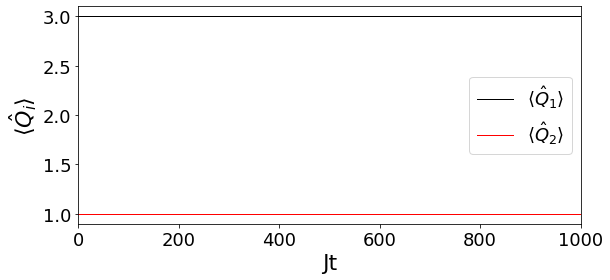

In [ ]:
N=6

U=-7
J=1

fs = init_fs(N, 0, 0, 0)

#Calcular o Hamiltoniano
H = hamiltoniano(U, J, N, 0, 0)

# Extrair os autovalores e autovetores
eigvals, eigstates = np.linalg.eigh(H)

t = np.linspace(0, 1000, 200)

#Calcular as correntes
Q1, Q2 = Qs(N)

expVal1 = dinamica(t, Q1, fs, eigstates, eigvals)
expVal2 = dinamica(t, Q2, fs, eigstates, eigvals)

plt.figure(figsize=(9,4))

plt.plot(t, expVal1, linewidth=1, c='k', label=r'$\langle \hat{Q}_{1} \rangle$')
plt.plot(t, expVal2, linewidth=1, c='r', label=r'$\langle \hat{Q}_{2} \rangle$')

plt.ylabel(r'$\langle \hat{Q}_{i}\rangle$', fontsize=22)
plt.xlabel("Jt", fontsize=22)

plt.xlim(0, 1000)
#plt.ylim(0, 1)

plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

plt.legend(fontsize=18)
plt.show()

Painel do protocolo numérico + dinâmicas com corrente

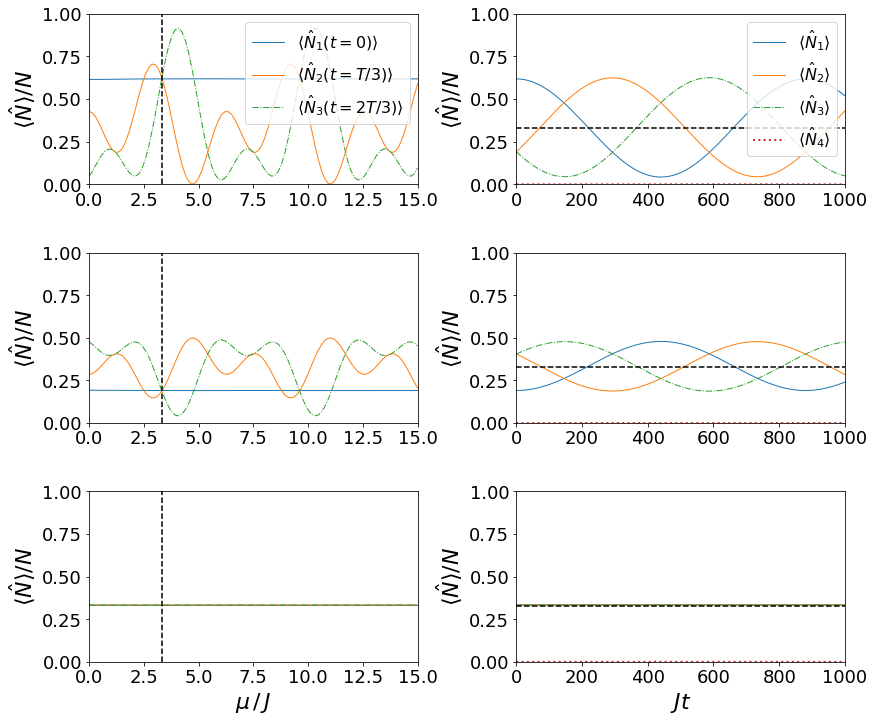

In [ ]:
N=6
N4=0

U=-7
J=1

dt=1
tau=200

Jeff = ((J/np.sqrt(3))**2)*(N+1)/(4*U*(N-2*N4-1)*(N-2*N4+1))
T = (2*np.pi/(3*np.abs(Jeff)))

fs1 = init_fs(N-N4, 0, 0, N4)
fs2 = init_fs(0, (N-N4)/2, (N-N4)/2, N4)
fs3 = init_fs((N-N4)/3, (N-N4)/3, (N-N4)/3, N4)

N1,N2,N3,N4 = matrizesN(N)

mu = np.linspace(0, 15, 100)

expValueN11 = np.zeros((100,1), dtype=complex)
expValueuN21 = np.zeros((100,1), dtype=complex)
expValueuN31 = np.zeros((100,1), dtype=complex)

expValueN12 = np.zeros((100,1), dtype=complex)
expValueuN22 = np.zeros((100,1), dtype=complex)
expValueuN32 = np.zeros((100,1), dtype=complex)

expValueN13 = np.zeros((100,1), dtype=complex)
expValueuN23 = np.zeros((100,1), dtype=complex)
expValueuN33 = np.zeros((100,1), dtype=complex)

uN2 = np.matmul(np.conjugate(Uhat(U, J, N, T/3, 0, 0)).T, np.matmul(N2, Uhat(U, J, N, T/3, 0, 0)))
uN3 = np.matmul(np.conjugate(Uhat(U, J, N, 2*T/3, 0, 0)).T, np.matmul(N3, Uhat(U, J, N, 2*T/3, 0, 0)))

i=0
for m in mu:
  thisPhi1 = FS_PHI(U, J, N, m, 0, dt, tau, fs1)
  thisPhi2 = FS_PHI(U, J, N, m, 0, dt, tau, fs2)
  thisPhi3 = FS_PHI(U, J, N, m, 0, dt, tau, fs3)

  expValueN11[i] = np.matmul(np.conjugate(thisPhi1).T, np.matmul(N1, thisPhi1))
  expValueuN21[i] = np.matmul(np.conjugate(thisPhi1).T, np.matmul(uN2, thisPhi1))
  expValueuN31[i] = np.matmul(np.conjugate(thisPhi1).T, np.matmul(uN3, thisPhi1))

  expValueN12[i] = np.matmul(np.conjugate(thisPhi2).T, np.matmul(N1, thisPhi2))
  expValueuN22[i] = np.matmul(np.conjugate(thisPhi2).T, np.matmul(uN2, thisPhi2))
  expValueuN32[i] = np.matmul(np.conjugate(thisPhi2).T, np.matmul(uN3, thisPhi2))

  expValueN13[i] = np.matmul(np.conjugate(thisPhi3).T, np.matmul(N1, thisPhi3))
  expValueuN23[i] = np.matmul(np.conjugate(thisPhi3).T, np.matmul(uN2, thisPhi3))
  expValueuN33[i] = np.matmul(np.conjugate(thisPhi3).T, np.matmul(uN3, thisPhi3))

  i += 1

fig, ax = plt.subplots(3, 2)

#Protocolos numéricos

ax[0][0].plot(mu, expValueN11.real/N, linewidth=1, label=r'$\langle \hat{N}_{1}(t=0) \rangle$')
ax[0][0].plot(mu, expValueuN21.real/N, linewidth=1, label=r'$\langle \hat{N}_{2}(t=T/3) \rangle$')
ax[0][0].plot(mu, expValueuN31.real/N, "-.", linewidth=1, label=r'$\langle \hat{N}_{3}(t=2T/3) \rangle$')
ax[0][0].axvline(x = 3.33, color = 'k', ls = '--')

ax[0][0].set_ylabel(r'$\langle \hat{N} \rangle /N$', fontsize=22)

ax[1][0].plot(mu, expValueN12.real/N, linewidth=1)
ax[1][0].plot(mu, expValueuN22.real/N, linewidth=1)
ax[1][0].plot(mu, expValueuN32.real/N, "-.", linewidth=1)
ax[1][0].axvline(x = 3.33, color = 'k', ls = '--')

ax[1][0].set_ylabel(r'$\langle \hat{N} \rangle /N$', fontsize=22)

ax[2][0].plot(mu, expValueN13.real/N, linewidth=1)
ax[2][0].plot(mu, expValueuN23.real/N, linewidth=1)
ax[2][0].plot(mu, expValueuN33.real/N, "-.", linewidth=1)
ax[2][0].axvline(x = 3.33, color = 'k', ls = '--')

ax[2][0].set_ylabel(r'$\langle \hat{N} \rangle /N$', fontsize=22)
ax[2][0].set_xlabel(r'$\mu\,/\,J$', fontsize=22)

smu = 3.33

#Hamiltoniano
#H = hamiltoniano(U, J, N, 0, 0)
H = hamiltoniano_efetivo(U, J, N, N4)

#Autovalores e autovetores
eigvals, eigstates = np.linalg.eigh(H)

t = np.linspace(0, 1000, 1500)

thisPhi1 = FS_PHI(U, J, N, smu, 0, dt, tau, fs1)
thisPhi2 = FS_PHI(U, J, N, smu, 0, dt, tau, fs2)
thisPhi3 = FS_PHI(U, J, N, smu, 0, dt, tau, fs3)

#Dinâmicas para os protocolos

ax[0][1].plot(t, dinamica(t, N1, thisPhi1, eigstates, eigvals)/N, linewidth=1, label=r'$\langle \hat{N}_{1} \rangle$')
ax[0][1].plot(t, dinamica(t, N2, thisPhi1, eigstates, eigvals)/N, linewidth=1, label=r'$\langle \hat{N}_{2} \rangle$')
ax[0][1].plot(t, dinamica(t, N3, thisPhi1, eigstates, eigvals)/N, "-.", linewidth=1, label=r'$\langle \hat{N}_{3} \rangle$')
ax[0][1].plot(t, dinamica(t, N4, thisPhi1, eigstates, eigvals)/N, ":", linewidth=2, label=r'$\langle \hat{N}_{4} \rangle$')
ax[0][1].axhline(y = 0.33, color = 'k', ls = '--')

ax[0][1].set_ylabel(r'$\langle \hat{N} \rangle /N$', fontsize=22)

ax[1][1].plot(t, dinamica(t, N1, thisPhi2, eigstates, eigvals)/N, linewidth=1)
ax[1][1].plot(t, dinamica(t, N2, thisPhi2, eigstates, eigvals)/N, linewidth=1)
ax[1][1].plot(t, dinamica(t, N3, thisPhi2, eigstates, eigvals)/N, "-.", linewidth=1)
ax[1][1].plot(t, dinamica(t, N4, thisPhi2, eigstates, eigvals)/N, ":", linewidth=2)
ax[1][1].axhline(y = 0.33, color = 'k', ls = '--')

ax[1][1].set_ylabel(r'$\langle \hat{N} \rangle /N$', fontsize=22)

ax[2][1].plot(t, dinamica(t, N1, thisPhi3, eigstates, eigvals)/N, linewidth=1)
ax[2][1].plot(t, dinamica(t, N2, thisPhi3, eigstates, eigvals)/N, linewidth=1)
ax[2][1].plot(t, dinamica(t, N3, thisPhi3, eigstates, eigvals)/N, "-.", linewidth=1)
ax[2][1].plot(t, dinamica(t, N4, thisPhi3, eigstates, eigvals)/N, ":", linewidth=2)
ax[2][1].axhline(y = 0.33, color = 'k', ls = '--')

ax[2][1].set_ylabel(r'$\langle \hat{N} \rangle /N$', fontsize=22)
ax[2][1].set_xlabel(r'$Jt$', fontsize=22)

for i in range(3):
  for j in range(2):
    if j==0:
      ax[i][j].set_xlim([0, 15])
    else:
      ax[i][j].set_xlim([0, 1000])

    ax[i][j].set_ylim([0, 1])
    ax[i][j].tick_params(axis='x', labelsize=18)
    ax[i][j].tick_params(axis='y', labelsize=18)

ax[0][0].legend(loc='upper right', fontsize=16)
ax[0][1].legend(loc='upper right', fontsize=16)

# Set the ticks for all axes
#plt.setp(ax, yticks=[0, 0.5, 1])

plt.subplots_adjust(left=0.1,
                    bottom=0.2, 
                    right=0.8, 
                    top=0.8, 
                    wspace=0.3, 
                    hspace=0.4)

fig.set_size_inches(15, 15)

#fig.savefig('protocolo_dinamica_132.png', dpi=fig.dpi)

plt.show()

Painel de dinâmica sentido 123 + dinâmica sentido 132

N=8 e N4=2


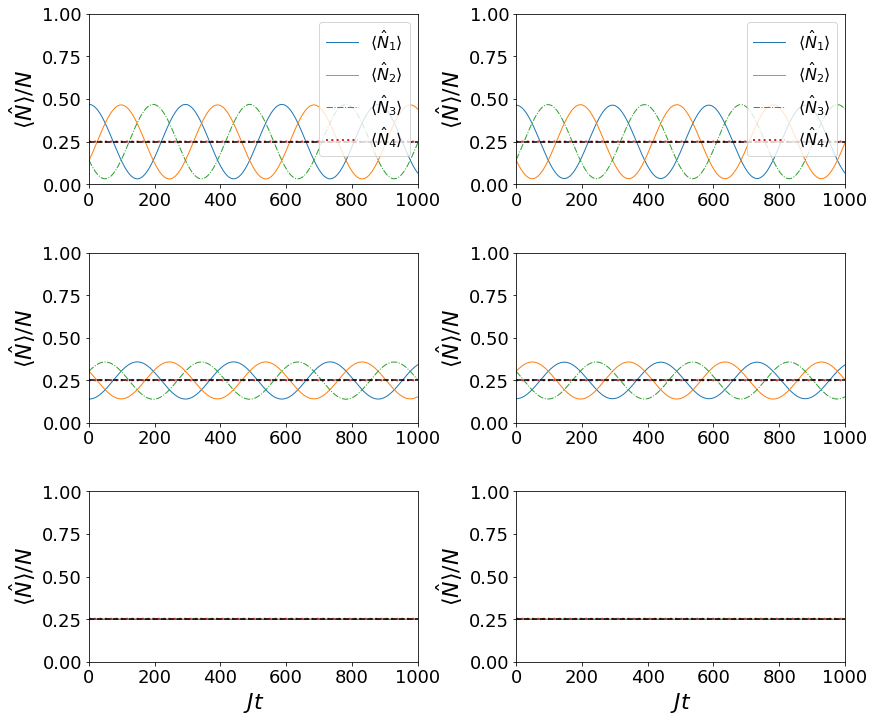

In [ ]:
N=8
k=2

U=-7
J=1

dt=1
tau=359

Jeff = ((J/np.sqrt(3))**2)*(N+1)/(4*U*(N-2*N4-1)*(N-2*N4+1))
T = (2*np.pi/(3*np.abs(Jeff)))

fs1 = init_fs(N-k, 0, 0, k)
fs2 = init_fs(0, (N-k)/2, (N-k)/2, k)
fs3 = init_fs((N-k)/3, (N-k)/3, (N-k)/3, k)

N1,N2,N3,N4 = matrizesN(N)

smu = 3.33
smu2 = 1.235

#Hamiltoniano
#H = hamiltoniano(U, J, N, 0, 0)
H = hamiltoniano_efetivo(U, J, N, k)

#Autovalores e autovetores
eigvals, eigstates = np.linalg.eigh(H)

t = np.linspace(0, 1000, 1500)

thisPhi1 = FS_PHI(U, J, N, smu, 0, dt, tau, fs1)
thisPhi2 = FS_PHI(U, J, N, smu, 0, dt, tau, fs2)
thisPhi3 = FS_PHI(U, J, N, smu, 0, dt, tau, fs3)

fig, ax = plt.subplots(3, 2)

#Dinâmicas 1 -> 2 -> 3

ax[0][0].plot(t, dinamica(t, N1, thisPhi1, eigstates, eigvals)/N, linewidth=1, label=r'$\langle \hat{N}_{1} \rangle$')
ax[0][0].plot(t, dinamica(t, N2, thisPhi1, eigstates, eigvals)/N, linewidth=1, label=r'$\langle \hat{N}_{2} \rangle$')
ax[0][0].plot(t, dinamica(t, N3, thisPhi1, eigstates, eigvals)/N, "-.", linewidth=1, label=r'$\langle \hat{N}_{3} \rangle$')
ax[0][0].plot(t, dinamica(t, N4, thisPhi1, eigstates, eigvals)/N, ":", linewidth=2, label=r'$\langle \hat{N}_{4} \rangle$')
ax[0][0].axhline(y = 0.25, color = 'k', ls = '--')

ax[0][0].set_ylabel(r'$\langle \hat{N} \rangle /N$', fontsize=22)

ax[1][0].plot(t, dinamica(t, N1, thisPhi2, eigstates, eigvals)/N, linewidth=1)
ax[1][0].plot(t, dinamica(t, N2, thisPhi2, eigstates, eigvals)/N, linewidth=1)
ax[1][0].plot(t, dinamica(t, N3, thisPhi2, eigstates, eigvals)/N, "-.", linewidth=1)
ax[1][0].plot(t, dinamica(t, N4, thisPhi2, eigstates, eigvals)/N, ":", linewidth=2)
ax[1][0].axhline(y = 0.25, color = 'k', ls = '--')

ax[1][0].set_ylabel(r'$\langle \hat{N} \rangle /N$', fontsize=22)

ax[2][0].plot(t, dinamica(t, N1, thisPhi3, eigstates, eigvals)/N, linewidth=1)
ax[2][0].plot(t, dinamica(t, N2, thisPhi3, eigstates, eigvals)/N, linewidth=1)
ax[2][0].plot(t, dinamica(t, N3, thisPhi3, eigstates, eigvals)/N, "-.", linewidth=1)
ax[2][0].plot(t, dinamica(t, N4, thisPhi3, eigstates, eigvals)/N, ":", linewidth=2)
ax[2][0].axhline(y = 0.25, color = 'k', ls = '--')

ax[2][0].set_ylabel(r'$\langle \hat{N} \rangle /N$', fontsize=22)
ax[2][0].set_xlabel(r'$Jt$', fontsize=22)

thisPhi1 = FS_PHI(U, J, N, smu2, 0, dt, tau, fs1)
thisPhi2 = FS_PHI(U, J, N, smu2, 0, dt, tau, fs2)
thisPhi3 = FS_PHI(U, J, N, smu2, 0, dt, tau, fs3)

#Dinâmicas 1 -> 3 -> 2

ax[0][1].plot(t, dinamica(t, N1, thisPhi1, eigstates, eigvals)/N, linewidth=1, label=r'$\langle \hat{N}_{1} \rangle$')
ax[0][1].plot(t, dinamica(t, N2, thisPhi1, eigstates, eigvals)/N, linewidth=1, label=r'$\langle \hat{N}_{2} \rangle$')
ax[0][1].plot(t, dinamica(t, N3, thisPhi1, eigstates, eigvals)/N, "-.", linewidth=1, label=r'$\langle \hat{N}_{3} \rangle$')
ax[0][1].plot(t, dinamica(t, N4, thisPhi1, eigstates, eigvals)/N, ":", linewidth=2, label=r'$\langle \hat{N}_{4} \rangle$')
ax[0][1].axhline(y = 0.25, color = 'k', ls = '--')

ax[0][1].set_ylabel(r'$\langle \hat{N} \rangle /N$', fontsize=22)

ax[1][1].plot(t, dinamica(t, N1, thisPhi2, eigstates, eigvals)/N, linewidth=1)
ax[1][1].plot(t, dinamica(t, N2, thisPhi2, eigstates, eigvals)/N, linewidth=1)
ax[1][1].plot(t, dinamica(t, N3, thisPhi2, eigstates, eigvals)/N, "-.", linewidth=1)
ax[1][1].plot(t, dinamica(t, N4, thisPhi2, eigstates, eigvals)/N, ":", linewidth=2)
ax[1][1].axhline(y = 0.25, color = 'k', ls = '--')

ax[1][1].set_ylabel(r'$\langle \hat{N} \rangle /N$', fontsize=22)

ax[2][1].plot(t, dinamica(t, N1, thisPhi3, eigstates, eigvals)/N, linewidth=1)
ax[2][1].plot(t, dinamica(t, N2, thisPhi3, eigstates, eigvals)/N, linewidth=1)
ax[2][1].plot(t, dinamica(t, N3, thisPhi3, eigstates, eigvals)/N, "-.", linewidth=1)
ax[2][1].plot(t, dinamica(t, N4, thisPhi3, eigstates, eigvals)/N, ":", linewidth=2)
ax[2][1].axhline(y = 0.25, color = 'k', ls = '--')

ax[2][1].set_ylabel(r'$\langle \hat{N} \rangle /N$', fontsize=22)
ax[2][1].set_xlabel(r'$Jt$', fontsize=22)

for i in range(3):
  for j in range(2):
    ax[i][j].set_xlim([0, 1000])
    ax[i][j].set_ylim([0, 1])
    ax[i][j].tick_params(axis='x', labelsize=18)
    ax[i][j].tick_params(axis='y', labelsize=18)

ax[0][0].legend(loc='upper right', fontsize=16)
ax[0][1].legend(loc='upper right', fontsize=16)

# Set the ticks for all axes
#plt.setp(ax, yticks=[0, 0.5, 1])

plt.subplots_adjust(left=0.1,
                    bottom=0.2, 
                    right=0.8, 
                    top=0.8, 
                    wspace=0.3, 
                    hspace=0.4)

fig.set_size_inches(15, 15)

#fig.savefig('protocolo_dinamica_132.png', dpi=fig.dpi)

plt.show()

Dinâmica - Resultados analíticos

In [ ]:
def fphi(phi):
  return (1/3)*(np.exp(2*(1j)*phi)+2*np.exp((-1j)*phi))

def gphi(phi):
  return (2/3)*(np.exp(2*(1j)*phi)-np.exp((-1j)*phi))

def val_esp_That(i, j, phi, theta):
  f = fphi(phi)
  g = gphi(phi)
  
  if i==1 and j==2:
    return (1/2)*(f*np.conjugate(g)*(np.exp(2*(1j)*theta)) + np.conjugate(f)*g*(np.exp(-2*(1j)*theta)))
  
  elif i==1 and j==3:
    return (1/2)*(f*np.conjugate(g)*(np.exp((1j)*theta)) + np.conjugate(f)*g*(np.exp(-(1j)*theta)))

  elif i==2 and j==3:
    return (1/2)*(np.abs(g)**2)*np.cos(theta)

def val_esp_Jhat(i, j, phi, theta):
  f = fphi(phi)
  g = gphi(phi)
  
  if i==1 and j==2:
    return ((1j)/2)*(f*np.conjugate(g)*(np.exp(2*(1j)*theta)) - np.conjugate(f)*g*(np.exp(-2*(1j)*theta)))
  
  elif i==1 and j==3:
    return ((1j)/2)*(f*np.conjugate(g)*(np.exp((1j)*theta)) - np.conjugate(f)*g*(np.exp(-(1j)*theta)))

  elif i==2 and j==3:
    return (1/2)*(np.abs(g)**2)*np.sin(theta)

def dinamica_analitica(k, t, t0, t1, mu, Jeff):
  theta = -t1*mu
  phi = t0*Jeff
  varphi = t*Jeff
  
  f = fphi(phi)
  g = gphi(phi)

  val_esp_Jkij = val_esp_Jhat(1, 2, phi, theta) + val_esp_Jhat(1, 3, phi, theta) if k==1 else val_esp_Jhat(2, 3, phi, theta)-val_esp_Jhat(1, 2, phi, theta) if k==2 else -val_esp_Jhat(1, 3, phi, theta)-val_esp_Jhat(2, 3, phi, theta)

  val_esp_nk = np.abs(f)**2 if k==1 else (1/4)*np.abs(g)**2

  val_esp_Tij = val_esp_That(2, 3, phi, theta) if k==1 else val_esp_That(1, 3, phi, theta) if k==2 else val_esp_That(1, 2, phi, theta)
  val_esp_TkiTkj = val_esp_That(1, 2, phi, theta)+val_esp_That(1, 3, phi, theta) if k==1 else val_esp_That(1, 2, phi, theta)+val_esp_That(2, 3, phi, theta) if k==2 else val_esp_That(1, 3, phi, theta)+val_esp_That(2, 3, phi, theta)

  Ak = (2/9)*(1 - 3*val_esp_nk + val_esp_Tij - (1/2)*val_esp_TkiTkj)

  return val_esp_nk + 2*Ak*np.sin((3/2)*varphi)**2 - (1/3)*val_esp_Jkij*np.sin(3*varphi)


In [ ]:
np.conjugate(fphi(2))*gphi(2)

(-0.00885104741102978-0.1862769987992839j)

Painel dinâmica analítica-numérica

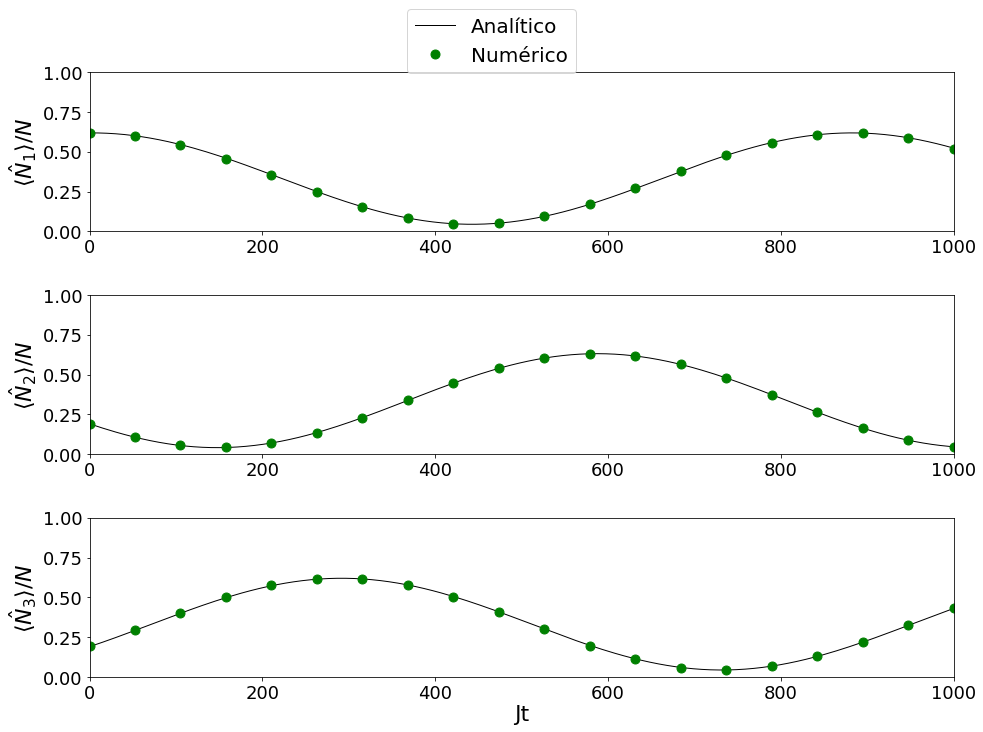

In [ ]:
N=6
N4=0

U=-7
J=1

dt=1
tau=200
mu=1.245

Jeff = ((J/np.sqrt(3))**2)*(N+1)/(4*U*(N-2*N4-1)*(N-2*N4+1))

t = np.linspace(0, 1000, 200)
t2 = np.linspace(0, 1000, 20)

fs = init_fs(N-N4, 0, 0, N4)

N1,N2,N3,_ = matrizesN(N)

#Hamiltoniano
H = hamiltoniano(U, J, N, 0, 0)

#Autovalores e autovetores
eigvals, eigstates = np.linalg.eigh(H)

thisPhi = FS_PHI(U, J, N, mu, 0, dt, tau, fs)

val_espN1_an = dinamica_analitica(1, t, tau, dt, mu, Jeff)
val_espN1_num = dinamica(t2, N1, thisPhi, eigstates, eigvals)/N

val_espN2_an = dinamica_analitica(2, t, tau, dt, mu, Jeff)
val_espN2_num = dinamica(t2, N2, thisPhi, eigstates, eigvals)/N

val_espN3_an = dinamica_analitica(3, t, tau, dt, mu, Jeff)
val_espN3_num = dinamica(t2, N3, thisPhi, eigstates, eigvals)/N

fig, ax = plt.subplots(3)

ax[0].plot(t, val_espN1_an.real, linewidth=1, c='k', label='Analítico')
ax[0].plot(t2, val_espN1_num.real, '.', markersize=18, linewidth=1, c='g', label='Numérico')
ax[1].plot(t, val_espN2_an.real, linewidth=1, c='k')
ax[1].plot(t2, val_espN2_num.real, '.', markersize=18, linewidth=1, c='g')
ax[2].plot(t, val_espN3_an.real, linewidth=1, c='k')
ax[2].plot(t2, val_espN3_num.real, '.', markersize=18, linewidth=1, c='g')

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', fontsize=20)

ax[0].set_xlim([0, 1000])
ax[0].set_ylim([0, 1])
ax[1].set_xlim([0, 1000])
ax[1].set_ylim([0, 1])
ax[2].set_xlim([0, 1000])
ax[2].set_ylim([0, 1])

ax[0].set_ylabel(r'$\langle \hat{N}_{1} \rangle/N$', fontsize=22)
ax[1].set_ylabel(r'$\langle \hat{N}_{2} \rangle/N$', fontsize=22)
ax[2].set_ylabel(r'$\langle \hat{N}_{3} \rangle/N$', fontsize=22)

# Set common labels
fig.text(0.5, 0.05, 'Jt', ha='center', va='center', fontsize=22)
#fig.text(0.05, 0.5, r'$\langle N_{1}-N_{2} \rangle/N$', ha='center', va='center', rotation='vertical', fontsize=14)

for eachax in ax:
  eachax.tick_params(axis='x', labelsize=18)
  eachax.tick_params(axis='y', labelsize=18)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

fig.set_size_inches(15, 10.5)
#fig.savefig('2pocos.png', dpi=fig.dpi)

plt.show()

$\langle\Phi|\mathcal{J}|\Phi\rangle$

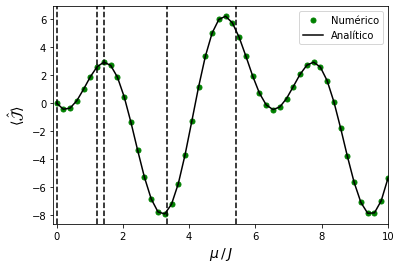

In [ ]:
N = 6
dim = int((N+3)*(N+2)*(N+1)/6) 
tau = 200
dt = 1

#Parâmetros de interação e tunelamento
U = -7
J = 1

Jeff = (J/np.sqrt(3))**2/(4*U*(N-1))

fs = est_inicial(N, 0, 0)

mu = np.linspace(0, 10, 50)
mu2 = np.linspace(0, 10, 50)

expValue = np.zeros((50,1), dtype=complex)
anExpValue = np.zeros((50,1), dtype=complex)

J21, J13, J32 = Jhat(N)

i=0
for m in mu:
  thisPhi = FS_PHI(U, J, N, m, 0, dt, tau, fs)
  expValue[i] = np.matmul((np.conjugate(thisPhi).T), np.matmul(J21+J13+J32, thisPhi))
  i += 1

anExpValue = (2/3)*N*np.sin(3*(tau)*Jeff)*(np.cos(2*mu2)-np.cos(mu2))-(4/9)*N*(np.sin(3*(tau)*Jeff/2)**2)*(np.sin(2*mu2)+np.sin(mu2))

plt.plot(mu2, expValue.real, ".", markersize=10, c='g', label='Numérico')
plt.plot(mu, anExpValue, "-", c='k', label='Analítico')
plt.axvline(x = 0, color = 'k', ls = '--')
plt.axvline(x = 1.235, color = 'k', ls = '--')
plt.axvline(x = 1.428, color = 'k', ls = '--')
#plt.axvline(x = 3.18, color = 'k', ls = '--')
plt.axvline(x = 3.33, color = 'k', ls = '--')
#plt.axvline(x = 5.075, color = 'k', ls = '--')
plt.axvline(x = 5.425, color = 'k', ls = '--')
#plt.axvline(x = 6.29, color = 'k', ls = '--')

#plt.axhline(y = 0, color = 'k', ls = '--')

plt.ylabel(r'$\langle \mathcal{\hat{J}} \rangle$', fontsize=14)
plt.xlabel(r'$\mu\,/\,J$', fontsize=14)

#plt.title(r'$|6, 0, 0, 0 \rangle$')

#plt.plot(dt, expValue.real)
plt.xlim(-0.1, 10)
#plt.ylim(-0.1, 0.1)
plt.legend() 
plt.show() 

Paineis Apêndice B (Correntes hamiltoniano vs correntes hamiltoniano efetivo)

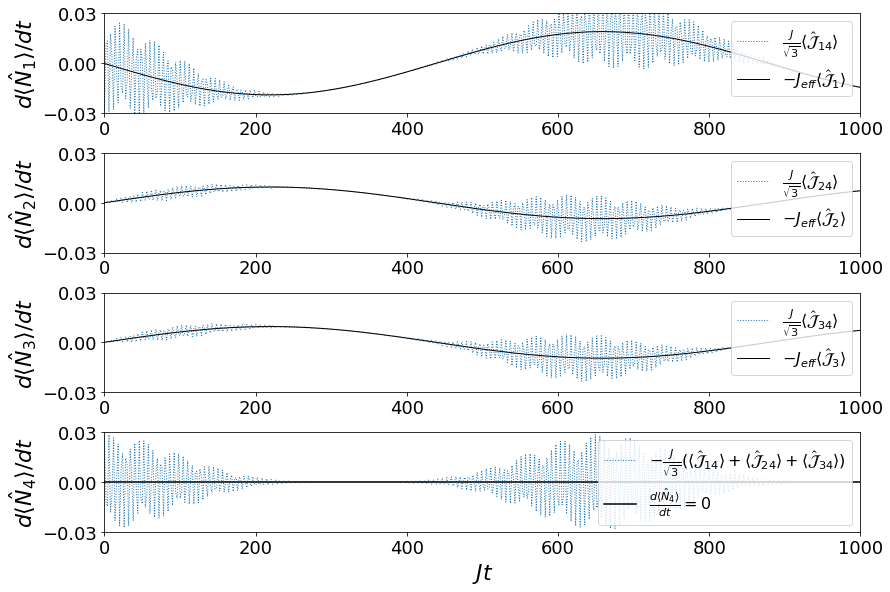

In [ ]:
N=6
N4=0

#Parâmetro de quebra de integrabilidade
m = 0

dt=1
tau=0

#Parâmetro de tunelamento
J = 1

#Parâmetro de interação
U = -7

Jeff = ((J/np.sqrt(3))**2)*(N+1)/(4*U*(N-2*N4-1)*(N-2*N4+1))
T = (2*np.pi/(3*np.abs(Jeff)))

#Calcular o Hamiltoniano
H = hamiltoniano(U, J, N, 0, 0)
#H = hamiltoniano_efetivo(U, J, N, N4)

# Extrair os autovalores e autovetores
eigvals, eigstates = np.linalg.eigh(H)

J12, J31, J23 = Jhat(N)

J14, J24, J34 = Jhat_4(N)

fs = init_fs(N-N4, 0, 0, N4)

this_phi = FS_PHI(U, J, N, m, 0, dt, tau, fs)

t = np.linspace(0, 1000, 500)

fig, ax = plt.subplots(4, 1)

expValue1 = dinamica(t, (J/np.sqrt(3))*J14, this_phi, eigstates, eigvals)
expValue2 = dinamica(t, -(J12-J31)*Jeff, this_phi, eigstates, eigvals)

expValue3 = dinamica(t, (J/np.sqrt(3))*J24, this_phi, eigstates, eigvals)
expValue4 = dinamica(t, -(J23-J12)*Jeff, this_phi, eigstates, eigvals)

expValue5 = dinamica(t, (J/np.sqrt(3))*J34, this_phi, eigstates, eigvals)
expValue6 = dinamica(t, -(J31-J23)*Jeff, this_phi, eigstates, eigvals)

expValue7 = dinamica(t, -(J/np.sqrt(3))*(J14+J24+J34), this_phi, eigstates, eigvals)

ax[0].plot(t, expValue1, ':', linewidth=1, label=r'$\frac{J}{\sqrt{3}}\langle \mathcal{\hat{J}}_{14} \rangle$')
ax[0].plot(t, expValue2, 'k', linewidth=1, label=r'$-J_{eff}\langle \mathcal{\hat{J}}_{1} \rangle$')

ax[0].set_ylabel(r'$d\langle \hat{N}_{1} \rangle/dt$', fontsize=22)

ax[1].plot(t, expValue3, ':', linewidth=1, label=r'$\frac{J}{\sqrt{3}}\langle \mathcal{\hat{J}}_{24} \rangle$')
ax[1].plot(t, expValue4, 'k', linewidth=1, label=r'$-J_{eff}\langle \mathcal{\hat{J}}_{2} \rangle$')

ax[1].set_ylabel(r'$d\langle \hat{N}_{2} \rangle/dt$', fontsize=22)

ax[2].plot(t, expValue5, ':', linewidth=1, label=r'$\frac{J}{\sqrt{3}}\langle \mathcal{\hat{J}}_{34} \rangle$')
ax[2].plot(t, expValue6, 'k', linewidth=1, label=r'$-J_{eff}\langle \mathcal{\hat{J}}_{3} \rangle$')

ax[2].set_ylabel(r'$d\langle \hat{N}_{3} \rangle/dt$', fontsize=22)

ax[3].plot(t, expValue7, ':', linewidth=1, label=r'$-\frac{J}{\sqrt{3}}(\langle \mathcal{\hat{J}}_{14} \rangle+\langle \mathcal{\hat{J}}_{24} \rangle+\langle \mathcal{\hat{J}}_{34} \rangle)$')
ax[3].axhline(y=0, c='k', label=r'$\frac{d\langle \hat{N}_{4} \rangle}{dt}=0$')

ax[3].set_ylabel(r'$d\langle \hat{N}_{4} \rangle/dt$', fontsize=22)
ax[3].set_xlabel(r'$Jt$', fontsize=22)

for i in range(4):
  ax[i].set_xlim([0, 1000])
  ax[i].set_ylim([-0.03, 0.03])
  ax[i].tick_params(axis='x', labelsize=18)
  ax[i].tick_params(axis='y', labelsize=18)
  ax[i].legend(loc='upper right', fontsize=16)

# Set the ticks for all axes
plt.setp(ax, yticks=[-0.03, 0, 0.03])

plt.subplots_adjust(left=0.1,
                    bottom=0.2, 
                    right=0.8, 
                    top=0.8, 
                    wspace=0.2, 
                    hspace=0.4)

fig.set_size_inches(15, 12)

#fig.savefig('3+1pocos.png', dpi=fig.dpi)

plt.show()

Painel da dinâmica no meu TCC

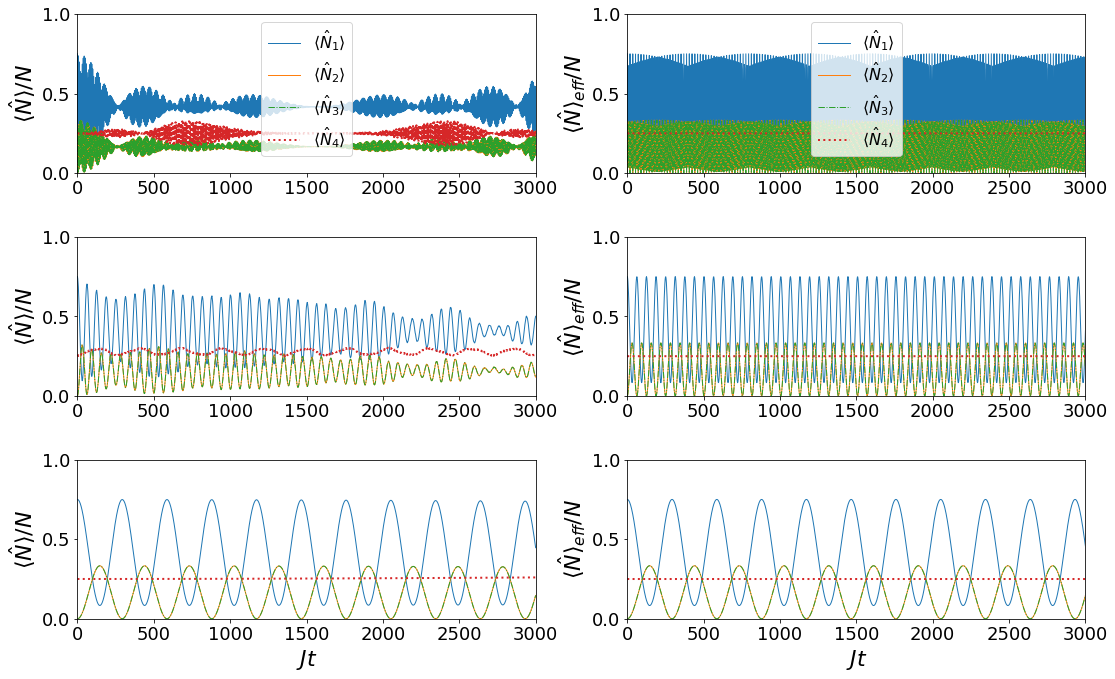

In [ ]:
N=8
N4=2

dim = int((N+3)*(N+2)*(N+1)/6)

#Parâmetro de quebra de integrabilidade
mu = 0

#Parâmetro de tunelamento
J = 1

#Parâmetros de interação
U_array = np.array([-7, -1.5, -0.001])

#Hamiltonianos
H_array = np.zeros((3, dim, dim))
Heff_array = np.zeros((3, dim, dim))

for i in range(3):
  H_array[i] = hamiltoniano(U_array[i], J, N, mu, 0)
  Heff_array[i] = hamiltoniano_efetivo(U_array[i], J, N, N4)

#Calcular o estado inicial
estado_inicial = init_fs(N-N4, 0, 0, N4)

#Calcular as matrizes N
N1, N2, N3, N4 = matrizesN(N)

t = np.linspace(0, 3000, 1500)

fig, ax = plt.subplots(3, 2)

#Autovalores e autovetores
eigvals, eigstates = np.linalg.eigh(H_array[2])

ax[0][0].plot(t, dinamica(t, N1, estado_inicial, eigstates, eigvals)/N, linewidth=1, label=r'$\langle \hat{N}_{1} \rangle$')
ax[0][0].plot(t, dinamica(t, N2, estado_inicial, eigstates, eigvals)/N, linewidth=1, label=r'$\langle \hat{N}_{2} \rangle$')
ax[0][0].plot(t, dinamica(t, N3, estado_inicial, eigstates, eigvals)/N, "-.", linewidth=1, label=r'$\langle \hat{N}_{3} \rangle$')
ax[0][0].plot(t, dinamica(t, N4, estado_inicial, eigstates, eigvals)/N, ":", linewidth=2, label=r'$\langle \hat{N}_{4} \rangle$')

ax[0][0].set_ylabel(r'$\langle \hat{N} \rangle /N$', fontsize=22)

#Autovalores e autovetores
eigvals, eigstates = np.linalg.eigh(H_array[1])

ax[1][0].plot(t, dinamica(t, N1, estado_inicial, eigstates, eigvals)/N, linewidth=1)
ax[1][0].plot(t, dinamica(t, N2, estado_inicial, eigstates, eigvals)/N, linewidth=1)
ax[1][0].plot(t, dinamica(t, N3, estado_inicial, eigstates, eigvals)/N, "-.", linewidth=1)
ax[1][0].plot(t, dinamica(t, N4, estado_inicial, eigstates, eigvals)/N, ":", linewidth=2)

ax[1][0].set_ylabel(r'$\langle \hat{N} \rangle /N$', fontsize=22)

#Autovalores e autovetores
eigvals, eigstates = np.linalg.eigh(H_array[0])

ax[2][0].plot(t, dinamica(t, N1, estado_inicial, eigstates, eigvals)/N, linewidth=1)
ax[2][0].plot(t, dinamica(t, N2, estado_inicial, eigstates, eigvals)/N, linewidth=1)
ax[2][0].plot(t, dinamica(t, N3, estado_inicial, eigstates, eigvals)/N, "-.", linewidth=1)
ax[2][0].plot(t, dinamica(t, N4, estado_inicial, eigstates, eigvals)/N, ":", linewidth=2)

ax[2][0].set_ylabel(r'$\langle \hat{N} \rangle /N$', fontsize=22)
ax[2][0].set_xlabel(r'$Jt$', fontsize=22)

#Autovalores e autovetores
eigvals, eigstates = np.linalg.eigh(Heff_array[2])

ax[0][1].plot(t, dinamica(t, N1, estado_inicial, eigstates, eigvals)/N, linewidth=1, label=r'$\langle \hat{N}_{1} \rangle$')
ax[0][1].plot(t, dinamica(t, N2, estado_inicial, eigstates, eigvals)/N, linewidth=1, label=r'$\langle \hat{N}_{2} \rangle$')
ax[0][1].plot(t, dinamica(t, N3, estado_inicial, eigstates, eigvals)/N, "-.", linewidth=1, label=r'$\langle \hat{N}_{3} \rangle$')
ax[0][1].plot(t, dinamica(t, N4, estado_inicial, eigstates, eigvals)/N, ":", linewidth=2, label=r'$\langle \hat{N}_{4} \rangle$')

ax[0][1].set_ylabel(r'$\langle \hat{N} \rangle_{eff} /N$', fontsize=22)

#Autovalores e autovetores
eigvals, eigstates = np.linalg.eigh(Heff_array[1])

ax[1][1].plot(t, dinamica(t, N1, estado_inicial, eigstates, eigvals)/N, linewidth=1)
ax[1][1].plot(t, dinamica(t, N2, estado_inicial, eigstates, eigvals)/N, linewidth=1)
ax[1][1].plot(t, dinamica(t, N3, estado_inicial, eigstates, eigvals)/N, "-.", linewidth=1)
ax[1][1].plot(t, dinamica(t, N4, estado_inicial, eigstates, eigvals)/N, ":", linewidth=2)

ax[1][1].set_ylabel(r'$\langle \hat{N} \rangle_{eff} /N$', fontsize=22)

#Autovalores e autovetores
eigvals, eigstates = np.linalg.eigh(Heff_array[0])

ax[2][1].plot(t, dinamica(t, N1, estado_inicial, eigstates, eigvals)/N, linewidth=1)
ax[2][1].plot(t, dinamica(t, N2, estado_inicial, eigstates, eigvals)/N, linewidth=1)
ax[2][1].plot(t, dinamica(t, N3, estado_inicial, eigstates, eigvals)/N, "-.", linewidth=1)
ax[2][1].plot(t, dinamica(t, N4, estado_inicial, eigstates, eigvals)/N, ":", linewidth=2)

ax[2][1].set_ylabel(r'$\langle \hat{N} \rangle_{eff} /N$', fontsize=22)
ax[2][1].set_xlabel(r'$Jt$', fontsize=22)

for i in range(3):
  for j in range(2):
    ax[i][j].set_xlim([0, 3000])
    ax[i][j].set_ylim([0, 1])
    ax[i][j].tick_params(axis='x', labelsize=18)
    ax[i][j].tick_params(axis='y', labelsize=18)

ax[0][0].legend(loc="upper center", fontsize=16)
ax[0][1].legend(loc="upper center", fontsize=16)

# Set the ticks for all axes
plt.setp(ax, yticks=[0, 0.5, 1])

plt.subplots_adjust(left=0.1,
                    bottom=0.2, 
                    right=0.8, 
                    top=0.8, 
                    wspace=0.2, 
                    hspace=0.4)

fig.set_size_inches(20, 14)

#fig.savefig('3+1pocos.png', dpi=fig.dpi)

plt.show()

Energias

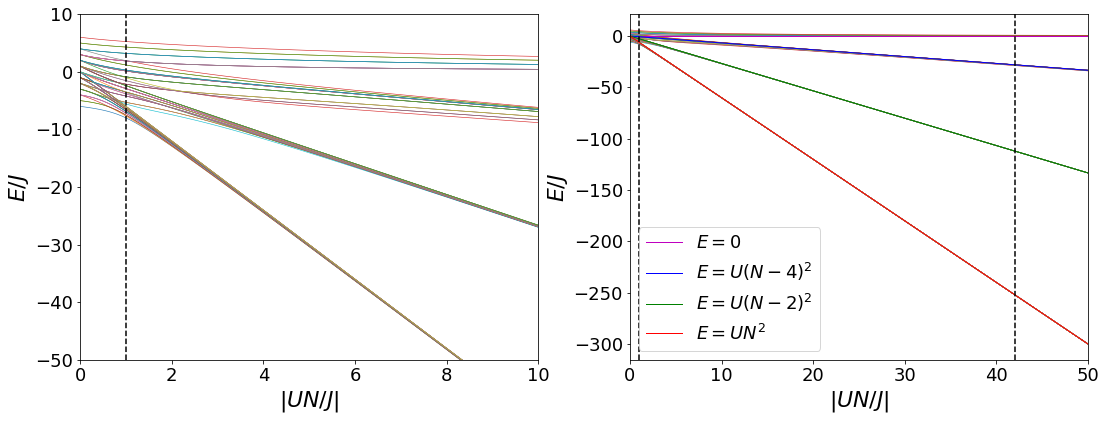

In [ ]:
J = 1                       
N = 6

dim = int((N+3)*(N+2)*(N+1)/6)

unj = np.linspace(0, 50, 100)
unj2 = np.linspace(0, 10, 100)

energies = np.zeros((np.size(unj),dim))
energies2 = np.zeros((np.size(unj2),dim))

fig, ax = plt.subplots(1,2)

i=0
for elem in unj2:
  Hteste = hamiltoniano(-J*elem/N, J, N, 0, 0)
  eigvals,_ = np.linalg.eigh(Hteste)
  energies2[i] = eigvals
  i += 1

for i in range(0,dim):
  ax[0].plot(unj2, energies2[:, i], linewidth=0.6) 

i=0
for elem in unj:
  Hteste = hamiltoniano(-J*elem/N, J, N, 0, 0)
  eigvals,_ = np.linalg.eigh(Hteste)
  energies[i] = eigvals
  i += 1

for i in range(0,dim):
  ax[1].plot(unj, energies[:, i], linewidth=0.6)

y1=-unj*N
y2 = (-unj + 4*unj/N)*(N-4)
y3 = (-unj + 2*unj/N)*(N-2)

ax[1].axhline(y=0, c='m', linewidth=1, label=r'$E=0$')
ax[1].plot(unj, y2, c='b', linewidth=1, label=r'$E=U(N-4)^{2}$')
ax[1].plot(unj, y3, c='g', linewidth=1, label=r'$E=U(N-2)^{2}$')
ax[1].plot(unj, y1, c='r', linewidth=1, label=r'$E=UN^{2}$')

ax[0].set_ylim([-50,10])
#ax[1].set_ylim([-112.5,-112])
ax[1].set_xlim([0,50])
ax[0].set_xlim([0,10])
#ax[0].set_xlim([4,6])

ax[0].tick_params(axis='x', labelsize=18)
ax[0].tick_params(axis='y', labelsize=18)

ax[1].tick_params(axis='x', labelsize=18)
ax[1].tick_params(axis='y', labelsize=18)

ax[0].set_xlabel("$|UN/J|$", fontsize=22)
ax[0].set_ylabel("$E/J$", fontsize=22)

ax[1].set_xlabel("$|UN/J|$", fontsize=22)
ax[1].set_ylabel("$E/J$", fontsize=22)

ax[0].axvline(x=1, c='k', ls="--")

ax[1].axvline(x=1, c='k', ls="--")
ax[1].axvline(x=42, c='k', ls="--")

ax[1].legend(loc='lower left', fontsize=18)

plt.subplots_adjust(left=0.1,
                    bottom=0.2, 
                    right=0.8, 
                    top=0.8, 
                    wspace=0.2, 
                    hspace=0.4)

fig.set_size_inches(20, 8)

plt.show()

Simulação de dinâmica

In [ ]:
def anima_31_pocos(t, expvals):
  figname = 'f{:.1f}.jpeg'.format(t)

  l = 6
  h = l*np.sqrt(3)/2

  poco1 = (0, h/2)
  poco2 = (-3, -h/2)
  poco3 = (3, -h/2)

  x = [0, -3, 3, 0]
  y = [h/2, -h/2, -h/2, -h/2+np.sqrt(3)*l/6]

  #expVal = [0, 0.5, 0, 0]

  plt.scatter(x, y, c=[0, 0, 0, 0], s=1000, vmin=0, vmax=1, cmap='viridis')

  plt.scatter(x, y, c=expvals, s=[x*1000 for x in expvals], vmin=0, vmax=1, cmap='viridis')

  plt.colorbar(label=r'$\langle N_{i} \rangle /N$', orientation="vertical")

  plt.xlim(-4, 4)
  plt.ylim(-4, 4)
  plt.axis('off')

  #plt.title('Tempo = {:.1f}'.format(t))

  plt.savefig(figname, dpi=100)           
  plt.close()

  return figname

In [ ]:
i=0
images = []

for it in t:
  figname = anima_31_pocos(it, [expVal1[i], expVal2[i], expVal3[i], expVal4[i]])
  images.append(imageio.imread(figname))
  os.remove(figname)

  i += 1

imageio.mimsave('fput.gif', images, fps=30)